## Import packages & set up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import torch
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from scipy.special import softmax

In [ ]:
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
file_path = '/content/drive/My Drive/BT4222 Project/EDA/bt4222_dataset_20.csv'
data = pd.read_csv(file_path)
print(data.head())

   Unnamed: 0  app_id                            app_name  review_id  \
0           0    4000                         Garry's Mod     297534   
1           1   48700              Mount & Blade: Warband     297695   
2           2   48700              Mount & Blade: Warband     321598   
3           3   35140  Batman: Arkham Asylum GOTY Edition     321586   
4           4     240              Counter-Strike: Source     321552   

                                              review  timestamp_updated  \
0  Now you too can make your very own creepy Pose...         1290229222   
1  All the thrill of killing groups of raiders on...         1290283941   
2  I really liked this game. You really can build...         1290984804   
3  The story seemed awesome at first, but then it...         1291337732   
4  awesome game. I was addicted to this for 5 years.         1291338488   

   recommended     author.steamid  author.num_games_owned  \
0         True  76561197967992446                    10

## Clean text

In [ ]:
data.shape

(126144, 30)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop=stopwords.words('english')

In [ ]:
data["review"] = data["review"].astype(str)

In [ ]:
import re
# remove symbols that Steam API uses to replace symbols it doesn't know
def replace_hearts(text):
    return re.sub(r"[♥]+", ' **** ' ,text)
data['review_text_clean'] = data.review.apply(replace_hearts)

## Visualising words

Common words in reviews:


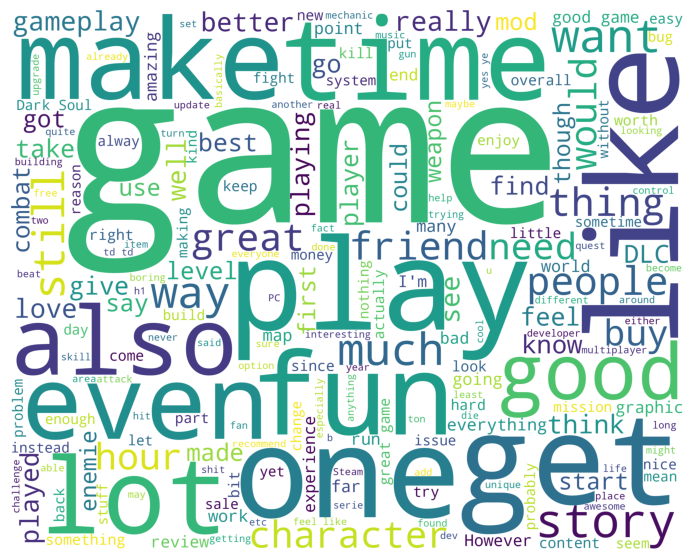

In [ ]:
from wordcloud import WordCloud
textdata= data['review']

# get word cloud to see word popularity
def wordcloud_draw(data, color = 'white'):
    words = ' '.join(data)
    words = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=stop,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(10, 7))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Common words in reviews:")
wordcloud_draw(textdata,'white')

## Get ratings via reviews using transformer from HuggingFace

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# load the model and tokenizer
model_name = "LiYuan/amazon-review-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# device set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# sentiment classification method
def get_sentiment_class(review):
    inputs = tokenizer(review, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=-1)
    return predicted_class.item()

data['pred_rating'] = data['review_text_clean'].apply(get_sentiment_class)
display(data)

,app_id,app_name,review_id,review,timestamp_updated,recommended,author.steamid,author.num_games_owned,author.playtime_at_review,Release date,...,is_free,owned_games,weighted_vote_score,votes_helpful,user_review_count,item_review_count,game_playtime_percentile,game_description,review_text_clean,pred_rating
0,4000,Garry's Mod,297534,Now you too can make your very own creepy Pose...,1290229222,True,76561197967992446,1037,287.0,"Nov 29, 2006",...,False,NaN,0.000000,0,29,2247,0.064850,"Casual,Indie,Simulation Single-player,Multi-pl...",Now you too can make your very own creepy Pose...,4
1,48700,Mount & Blade: Warband,297695,All the thrill of killing groups of raiders on...,1290283941,True,76561197967992446,1037,115.0,"Mar 31, 2010",...,False,NaN,0.000000,0,29,936,0.040143,"Action,RPG Single-player,Multi-player,Steam Ac...",All the thrill of killing groups of raiders on...,4
2,48700,Mount & Blade: Warband,321598,I really liked this game. You really can build...,1290984804,True,76561197968566119,587,6267.0,"Mar 31, 2010",...,False,NaN,0.000000,0,23,936,0.592607,"Action,RPG Single-player,Multi-player,Steam Ac...",I really liked this game. You really can build...,4
3,35140,Batman: Arkham Asylum GOTY Edition,321586,"The story seemed awesome at first, but then it...",1291337732,True,76561197968566119,587,96.0,"Mar 26, 2010",...,False,NaN,0.000000,0,23,597,0.075965,"Action,Adventure Single-player,Steam Achieveme...","The story seemed awesome at first, but then it...",2
4,240,Counter-Strike: Source,321552,awesome game. I was addicted to this for 5 years.,1291338488,True,76561197968566119,587,6277.0,"Nov 1, 2004",...,False,NaN,0.000000,0,23,931,0.814495,"Action Multi-player,Cross-Platform Multiplayer...",awesome game. I was addicted to this for 5 years.,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126139,418370,Resident Evil 7 Biohazard,85211070,topkek,1611417066,True,76561198112669681,379,217.0,"Jan 23, 2017",...,False,Counter-Strike (0 mins); Counter-Strike: Condi...,0.390071,0,66,688,0.110032,"Action,Adventure Single-player,Steam Achieveme...",topkek,4
126140,945360,Among Us,85214466,Among us is the best party game to play with f...,1611420812,True,76561198161141911,396,432.0,"Nov 16, 2018",...,False,NaN,0.516807,1,52,1138,0.528220,"Casual Multi-player,PvP,Online PvP,LAN PvP,Co-...",Among us is the best party game to play with f...,4
126141,359550,Tom Clancy's Rainbow Six Siege,85215160,Played this game for hundreds of hours over on...,1611421580,True,76561198161141911,396,517.0,"Dec 1, 2015",...,False,NaN,0.000000,0,52,2093,0.146497,"Action Single-player,Multi-player,PvP,Online P...",Played this game for hundreds of hours over on...,4
126142,271590,Grand Theft Auto V,85215416,"Yeah, I guess",1611421837,True,76561198035768259,113,789.0,"Apr 13, 2015",...,True,Half-Life: Opposing Force (253 mins); Half-Lif...,0.000000,0,21,2587,0.109372,"Action,Adventure Single-player,Multi-player,Pv...","Yeah, I guess",4


## Save dataset

In [ ]:
data.to_csv('bt4222_dataset_21.csv', index=False)

In [ ]:
from google.colab import files
files.download(f"./bt4222_dataset_21.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>